In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from scipy.optimize import minimize
import numpy as np

backend = Aer.get_backend('qasm_simulator')

In [2]:
def stateprep_node(gammas, betas, p = 1):
    q = QuantumRegister(n)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q, c)
    
    for i in range(n):
        circuit.h(q[i])
    
    circuit.barrier()
    
    for i in range(p):
        gamma = gammas[i]
        beta = betas[i]
        
        for node in nodes:
            theta = node[1]*(node[1]-2*L)*gamma
            circuit.u1(theta, q[node[0]])
        
        circuit.barrier()
        
        for edge in edges:
            theta = edge[2]*gamma
            node1 = edge[0]
            node2 = edge[1]
            circuit.cu1(theta, q[node1], q[node2])
        
        circuit.barrier()
        
        for node in nodes:
            circuit.rx(2*beta, q[node[0]])
        
        circuit.barrier()
        
    return circuit

In [3]:
def stateprep_edge(gammas, betas, p = 1):
    q = QuantumRegister(n)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)
    
    for i in range(n):
        circuit.h(q[i])
        
    circuit.barrier()
    
    for i in range(p):
        gamma = gammas[i]
        beta = betas[i]
        
        for node in nodes:
            theta = node[1]*(node[1]-2*L)*gamma
            circuit.u1(theta, q[node[0]])
            
        circuit.barrier()
            
        for edge in edges:
            theta = edge[2]*gamma
            node1 = edge[0]
            node2 = edge[1]
            circuit.cu1(theta, q[node1], q[node2])
            
        circuit.barrier()
            
        for node in nodes:
            circuit.rx(2*beta, q[node[0]])
            
        circuit.barrier()
            
    return circuit

In [4]:
def get_node_cost(gammas, betas, p, node):
    circuit = stateprep_node(gammas, betas, p)
    q = circuit.qubits
    c = circuit.clbits
    cost = 0
    weight = node[1]*(node[1]-2*L)/2
    cost += weight
    
    circuit.measure(q[node[0]], c)
    shots = 1000
    job = execute(circuit, backend, shots = shots)
    result = job.result()
    counts = result.get_counts()
    
    try:
        a_2 = counts['0']
    except:
        a_2 = 0
    try:
        b_2 = counts['1']
    except:
        b_2 = 0
        
    expval = (a_2 - b_2)/shots
    
    cost += -1*weight*expval
    
    return cost

In [5]:
def get_edge_cost(gammas, betas, p, edge):
    circuit = stateprep_edge(gammas, betas, p)
    q = circuit.qubits
    c = circuit.clbits
    cost = 0
    weight = edge[2]/4
    cost += weight
    circuit.measure(q[edge[0]], c[0])
    circuit.measure(q[edge[1]], c[1])
    shots = 1000
    job = execute(circuit, backend, shots = shots)
    result = job.result()
    counts = result.get_counts()
    
    try:
        a_2 = counts['00']
    except:
        a_2 = 0
    try:
        b_2 = counts['01']
    except:
        b_2 = 0
    try:
        c_2 = counts['10']
    except:
        c_2 = 0
    try:
        d_2 = counts['11']
    except:
        d_2 = 0
        
    expval = (- a_2 - b_2 - c_2 + 3*d_2)/shots
    
    cost += weight*expval
    
    return cost

In [6]:
def qaoa(beta_gamma):
    betas = beta_gamma[:l]
    gammas = beta_gamma[l:]
    
    optimizer_cost = 0
    
    for node in nodes:
        optimizer_cost += get_node_cost(gammas, betas, p, node)
    
    for edge in edges:
        optimizer_cost += get_edge_cost(gammas, betas, p, edge)
    
    optimizer_cost += L**2

    return optimizer_cost

In [7]:
def finalcircuit(gammas, betas, p = 1):
    q = QuantumRegister(n)
    c = ClassicalRegister(n)
    circuit = QuantumCircuit(q, c)
    
    for i in range(n):
        circuit.h(q[i])
    
    circuit.barrier()
    
    for i in range(p):
        gamma = gammas[i]
        beta = betas[i]
        
        for node in nodes:
            theta = node[1]*(node[1]-2*L)*gamma
            circuit.u1(theta, q[node[0]])
            
        circuit.barrier()
            
        for edge in edges:
            theta = edge[2]*gamma
            node1 = edge[0]
            node2 = edge[1]
            circuit.cu1(theta, q[node1], q[node2])
            
        circuit.barrier()
        
        for node in nodes:
            circuit.rx(2*beta, q[node[0]])
            
        circuit.barrier()
            
    return circuit

In [8]:
p = 5
L = 11
nodes = [(0, 3), (1, 8), (2, 5)]
n = len(nodes)
edges = []
for i in range(n):
    for j in range(i+1, n):
        weight = 2*nodes[i][1]*nodes[j][1]
        edges.append((i,j,weight))
beta = np.random.uniform(0, np.pi*2, p)
gamma = np.random.uniform(0, np.pi*2, p)
beta_gamma = np.concatenate([beta, gamma])
print('beta_gamma:',beta_gamma)
l = len(beta_gamma)//2

beta_gamma: [4.25535122 2.62668476 5.59124525 0.67425269 1.64482057 3.24637623
 2.74746145 1.07901191 1.15802967 2.61039495]


In [9]:
result = minimize(qaoa, beta_gamma, method='Cobyla')
result

     fun: 15.770999999999987
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 91
  status: 1
 success: True
       x: array([4.28405035, 3.59687213, 5.57193801, 0.67864044, 1.63160628,
       3.24957782, 2.74601737, 1.0647139 , 1.16800823, 2.58859988])

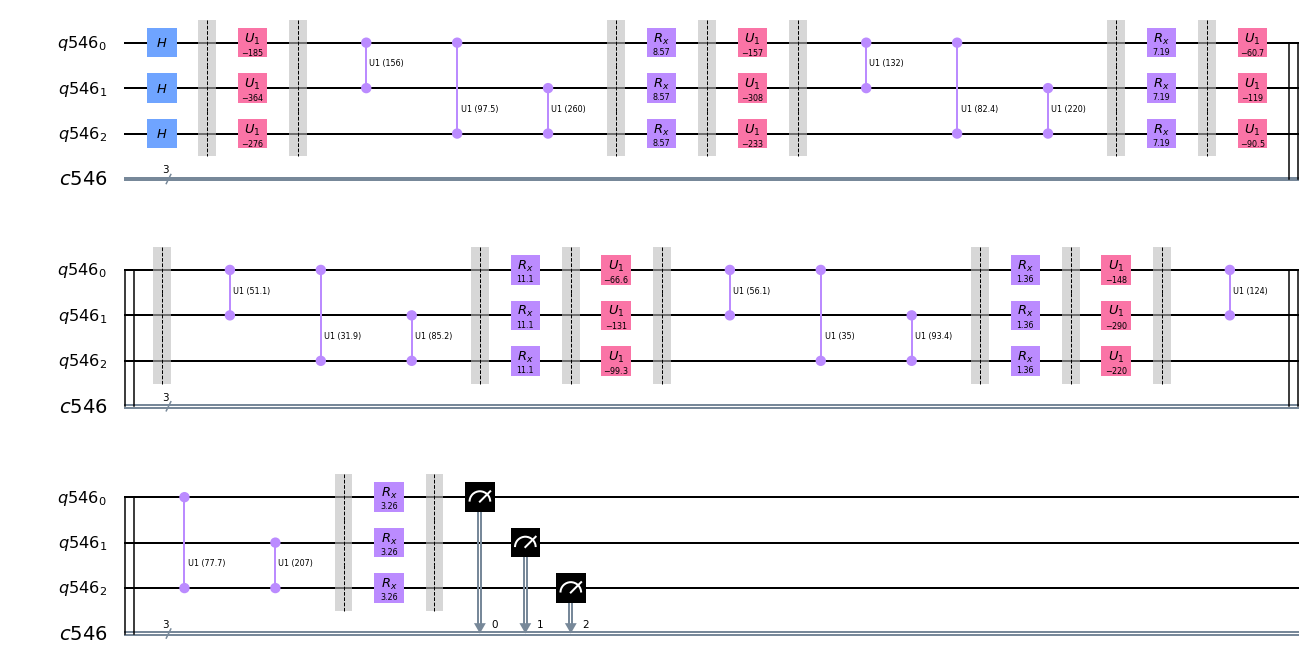

In [10]:
final_gammas = result.x[l:]
final_betas = result.x[:l]
final_circuit = finalcircuit(final_gammas, final_betas, p)
q_final = final_circuit.qubits
c_final = final_circuit.clbits
final_circuit.measure(q_final, c_final)
final_circuit.draw(output='mpl')

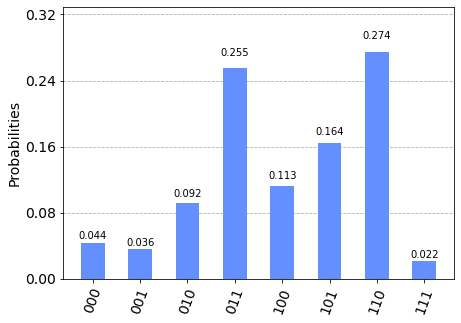

In [11]:
shots = 1000
job = execute(final_circuit, backend, shots = shots)
plot_histogram(job.result().get_counts(final_circuit))